In [1]:
# import libraries to read and plot statistical analyses of marine satellite data

In [2]:
%matplotlib inline


import pandas as pd
import xarray as xr
import numpy as np
import warnings
import cmocean as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import gridspec, ticker
from scipy.ndimage.filters import gaussian_filter
warnings.filterwarnings('ignore')
import glob
import seawater as sw
from dask.diagnostics import ProgressBar

### Open CMEMS dataset

In [3]:
fsource = sorted(glob.glob('/home/br/git/CMEMS/oc-cci-chl/oc_cci*'))

In [4]:
source   =  [xr.open_dataset(i, chunks={}) for i in fsource]
source = xr.concat(source, dim='time')

In [5]:
# load batimetria

dado = xr.open_dataset('/home/br/git/CMEMS/gebco-data/gebco_2020_n-20.0_s-40.0_w-60.0_e-40.0.nc')

## Mask shelf

In [12]:
mask= source.sel(longitude=slice(-50.0, -40.0), latitude=slice(-22.0, -28))

In [14]:
mask_bat = dado.interp({'lon':mask.longitude, 'lat':mask.latitude}).elevation
dado.close()
mask.close()

In [15]:
# print(mask_cdm)

### médias e plots de série temporal

In [ ]:
# with ProgressBar():
#     mean_chl = mask_cdm.mean(['longitude','latitude']).compute()

In [ ]:
# plt.figure(figsize=(6,2))
# np.log10(mean_chl).plot(x ="time" , color='green',linestyle='-')
# plt.title('oc-cci - clorophyll mass ')

In [ ]:
# plt.figure(figsize=(6,2))
# np.log10(mean_chl.sel(time=slice('2012','2020')).plot(x ="time" , color='green',linestyle='-')
# plt.title('oc-cci - clorophyll mass ')

#### Funçoes para diagramas de  Hovmollers 

In [16]:
# função montar uma matrix para um vetor de batimetria "suave #
def extract_bat(lon,lat,topo,level,flevel):
    CT = plt.contour(gaussian_filter(lon,flevel),
                     gaussian_filter(lat,flevel),gaussian_filter(topo,flevel),
                     [level],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    # CT = plt.contour(lon,lat,topo,[-100],colors='black',latlon=True,linewidths=0.7,linestyles='solid')
    lli = []
    for i in range(len(CT.allsegs[0])):
        print(CT.allsegs[0][i].shape[0])
        lli.append(CT.allsegs[0][i].shape[0])
        
    lbat = CT.allsegs[0][np.argmax(lli)]
    print('Maior shape é'.format(CT.allsegs[0][np.argmax(lli)].shape))

    return lbat[:,0],lbat[:,1]

In [17]:
def hov_ext_chl_dist(x,y,chl_file):

    hov_chl = []

    xi,yi = x.copy(),y.copy() 

    for i in range(len(xi)):
        print("{:03.1f}%".format(100*(i+1)/len(xi)),end="\r")
        hov_chl.append(source.sel(longitude=xi[i], latitude=yi[i], method='nearest'))

    hov_chl = xr.concat(hov_chl,dim='distance')
    hov_chl = hov_chl.assign_coords({'distance':np.hstack([0,np.cumsum(sw.dist(yi,xi)[0])])}) #


    with ProgressBar():
        hov_chl = hov_chl.compute()
        
    hov_chl = hov_chl.interpolate_na('distance').interpolate_na('time')
    
    return hov_chl

311
Maior shape é


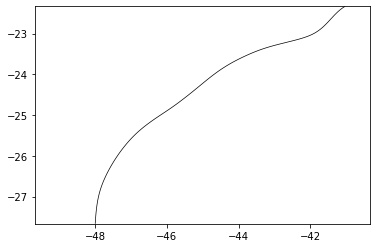

In [62]:
#----------- SELEÇÃO SEÇÕES DE ACORDO COM A BATIMETRIA SUAVE ---------------- #

xbat,ybat,zbat = mask_bat.lat.values,mask_bat.lon.values,mask_bat.values

x, y =  extract_bat(ybat, xbat, zbat, level = -80, flevel = 10) # SELECIONANDO VETORES
#x_1, y_1 = extract_bat(ybat, xbat, zbat, level = -100, flevel = 10)
#x_2, y_2 = extract_bat(ybat, xbat, zbat, level = -150, flevel = 10)
# x_3, y_3 = extract_bat(ybat, xbat, zbat, level = -200, flevel = 10)


x,y = x[::10],y[::10]
#x_1,y_1 = x_1[::100],y_1[::100] 
#x_2,y_2 = x_2[::100],y_2[::100]
# x_3,y_3 = x_3[::100],y_3[::100]

### Extraindo o dado a partir da batimetria selecionada

In [63]:
hov_chl  = hov_ext_chl_dist(x,y,source)
# hov_chl_1  = hov_ext_chl_dist(x_1,y_1,source)
# hov_chl_2 = hov_ext_chl_dist(x_2,y_2,source)
# hov_chl_3 = hov_ext_chl_dist(x_3,y_3,source)

[########################################] | 100% Completed | 19.9s


### Como salvar essa variavel em um novo arquivo (subset CMEMS time serie ) netcdf4?

In [ ]:
#pwd

In [ ]:
#hov_chl.to_netcdf()

In [ ]:
#print(hov_chl)

### teste correlaçao e covariancia entre os vetores.

In [ ]:
#xr.corr(hov_cdm.CDM, hov_cdm_2.CDM, dim="time")

In [ ]:
#xr.corr(hov_cdm_1.CDM, hov_cdm_2.CDM, dim="time")

In [ ]:
#xr.corr(hov_cdm_2.CDM, hov_cdm_3.CDM, dim="time")

### Plot - hovmolllers em diferentes escalas de tempo

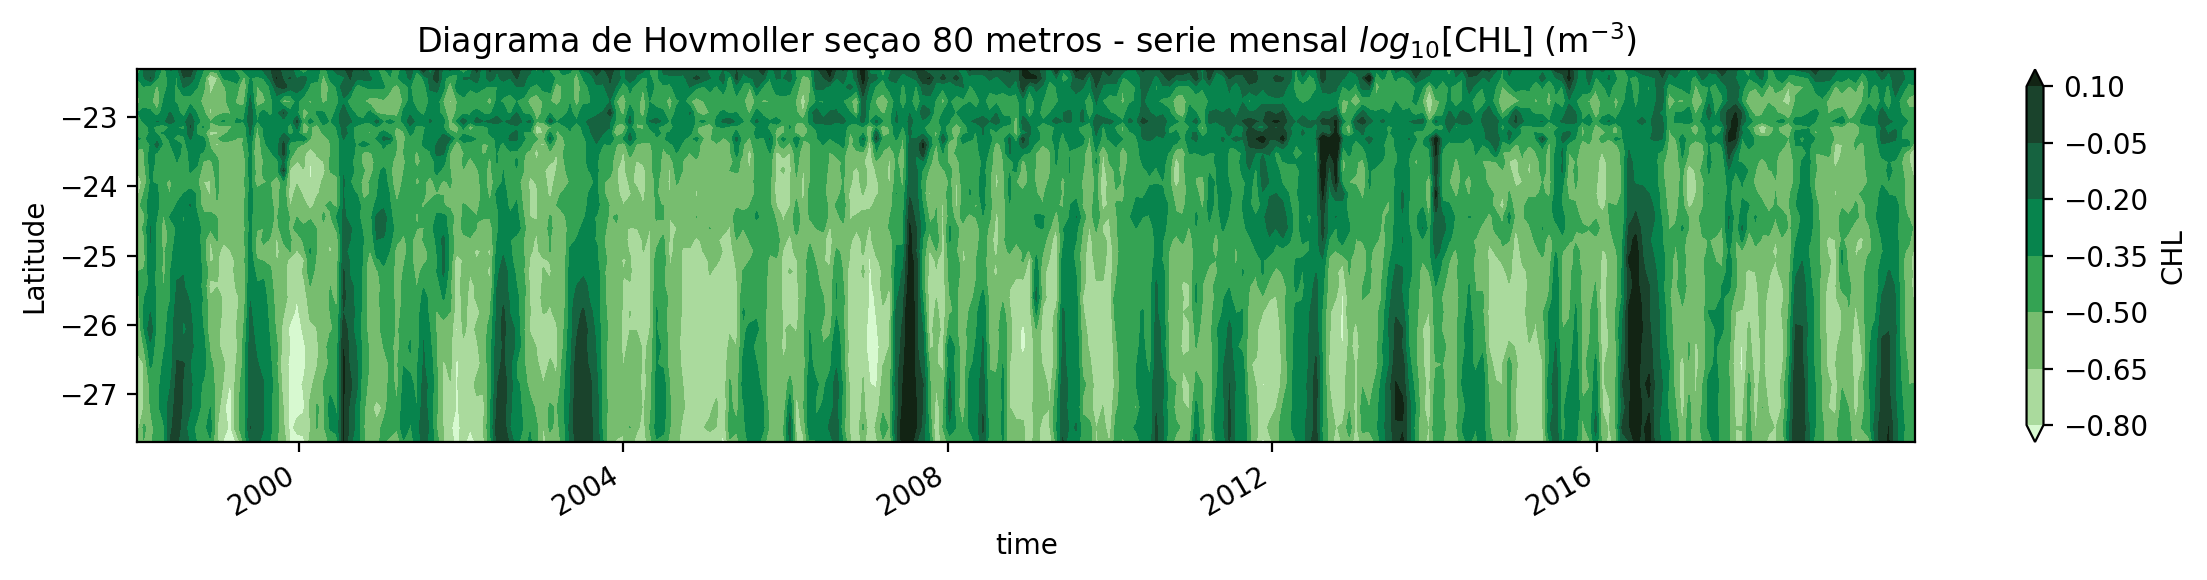

In [103]:
plt.figure(figsize=(12 ,3), dpi =200)
np.log10(hov_chl.CHL).resample({'time':'30D'}).mean().plot.contourf(
    y='latitude',vmin=-0.8,vmax= 0.1,cmap= cmo.cm.algae)
#plt.xlabel('month')
plt.ylabel('Latitude')
plt.title('Diagrama de Hovmoller seçao 80 metros - serie mensal ' r'$log_{10}$[CHL] (m$^{-3}$)')
plt.tight_layout()

# plt.figure(figsize=(8 ,2), dpi =200)
# np.log10(hov_chl_2.CHL).resample({'time':'30D'}).mean().plot.contourf(y='latitude', cmap= cmo.cm.algae,robust=True)
# #plt.xlabel('month')
# plt.ylabel('Latitude')
# #plt.title('Hovmoller Diagram of Chlorophyll-a concentration Monthly-mean time-serie - 50 m')
# #plt.tight_layout()

# plt.figure(figsize=(8 ,2), dpi =200)
# np.log10(hov_chl_3.CHL).resample({'time':'30D'}).mean().plot.contourf(y='latitude', cmap= cmo.cm.algae,robust=True)
# #plt.xlabel('month')
# plt.ylabel('Latitude')
# #plt.title('Hovmoller Diagram of Chlorophyll-a concentration Monthly-mean time-serie - 50 m')
# #plt.tight_layout()

In [ ]:
plt.figure(figsize=(6, 3))
np.log10(hov_chl.CHL).resample(
         {'time':'3D'} # reagrupando os dados
     ).mean().sel(
         time=slice('2016-01-01','2017-01-01') # slice para um ano especifico
     ).plot.contourf(y='latitude', cmap= cmo.cm.algae,robust=True)
plt.xlabel('Month')
plt.ylabel('Latitude [S]')
plt.title('3-daily mean of chlorophyll absorption  [m-3] - 50 m')

plt.figure(figsize=(6, 3))
np.log10(hov_chl.CHL).resample(
         {'time':'3D'} # reagrupando os dados
     ).mean().sel(
         time=slice('2018-01-01','2019-01-01') # slice para um ano especifico
     ).plot.contourf(y='latitude', cmap= cmo.cm.algae,robust=True)
plt.xlabel('Month')
plt.ylabel('Latitude [S]')
plt.title('3-daily mean of chlorophyll absorption  [m-3] - 50 m')